# Static Ordinal Regression with Diabetes Dataset using TensorFlow
---------

## Imports

In [1]:
# General
import sys, os
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
# sklearn
from sklearn.datasets import load_diabetes
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import MultiLabelBinarizer, KBinsDiscretizer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, precision_recall_curve, auc, confusion_matrix
from sklearn.decomposition import PCA

In [2]:
# tensorflow
import tensorflow as tf
import tensorflow_probability as tfp
from tensorflow_probability import bijectors as tfb
from tensorflow.keras.optimizers import Adam

In [3]:
# local
sys.path.append(os.path.abspath(os.path.join('../src')))
sys.path.append(os.path.abspath(os.path.join('../res')))
from clm_tensorflow.cumulative_link import CumulativeLink
from clm_tensorflow.negative_log_likelihood import NegativeLogLikelihood
from clm_tensorflow.plot_model import plot_model

## Data Preprocessing

In [4]:
# Set the random state and desired number of classes
random_state = 1
n_classes = 5

In [5]:
# Load Data
X, y = load_diabetes(return_X_y=True, as_frame=True)

In [6]:
# Train Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=random_state)

In [7]:
# Separate disease progression into ordinal classes
est = KBinsDiscretizer(n_bins=n_classes, encode='ordinal')
est.fit(y_train.to_frame())
y_train_ordinal = est.transform(y_train.to_frame()).astype(int)
y_test_ordinal = est.transform(y_test.to_frame()).astype(int)

### Visualize feature distributions for each label

We can use a pairplot to get a sense of the feature distributions and each's relationship to the ordinal class target. It should be noted that this is simply an exercise to get a sense of the data but should not be used to necessarily engineer features since it may not capture interactions between features.

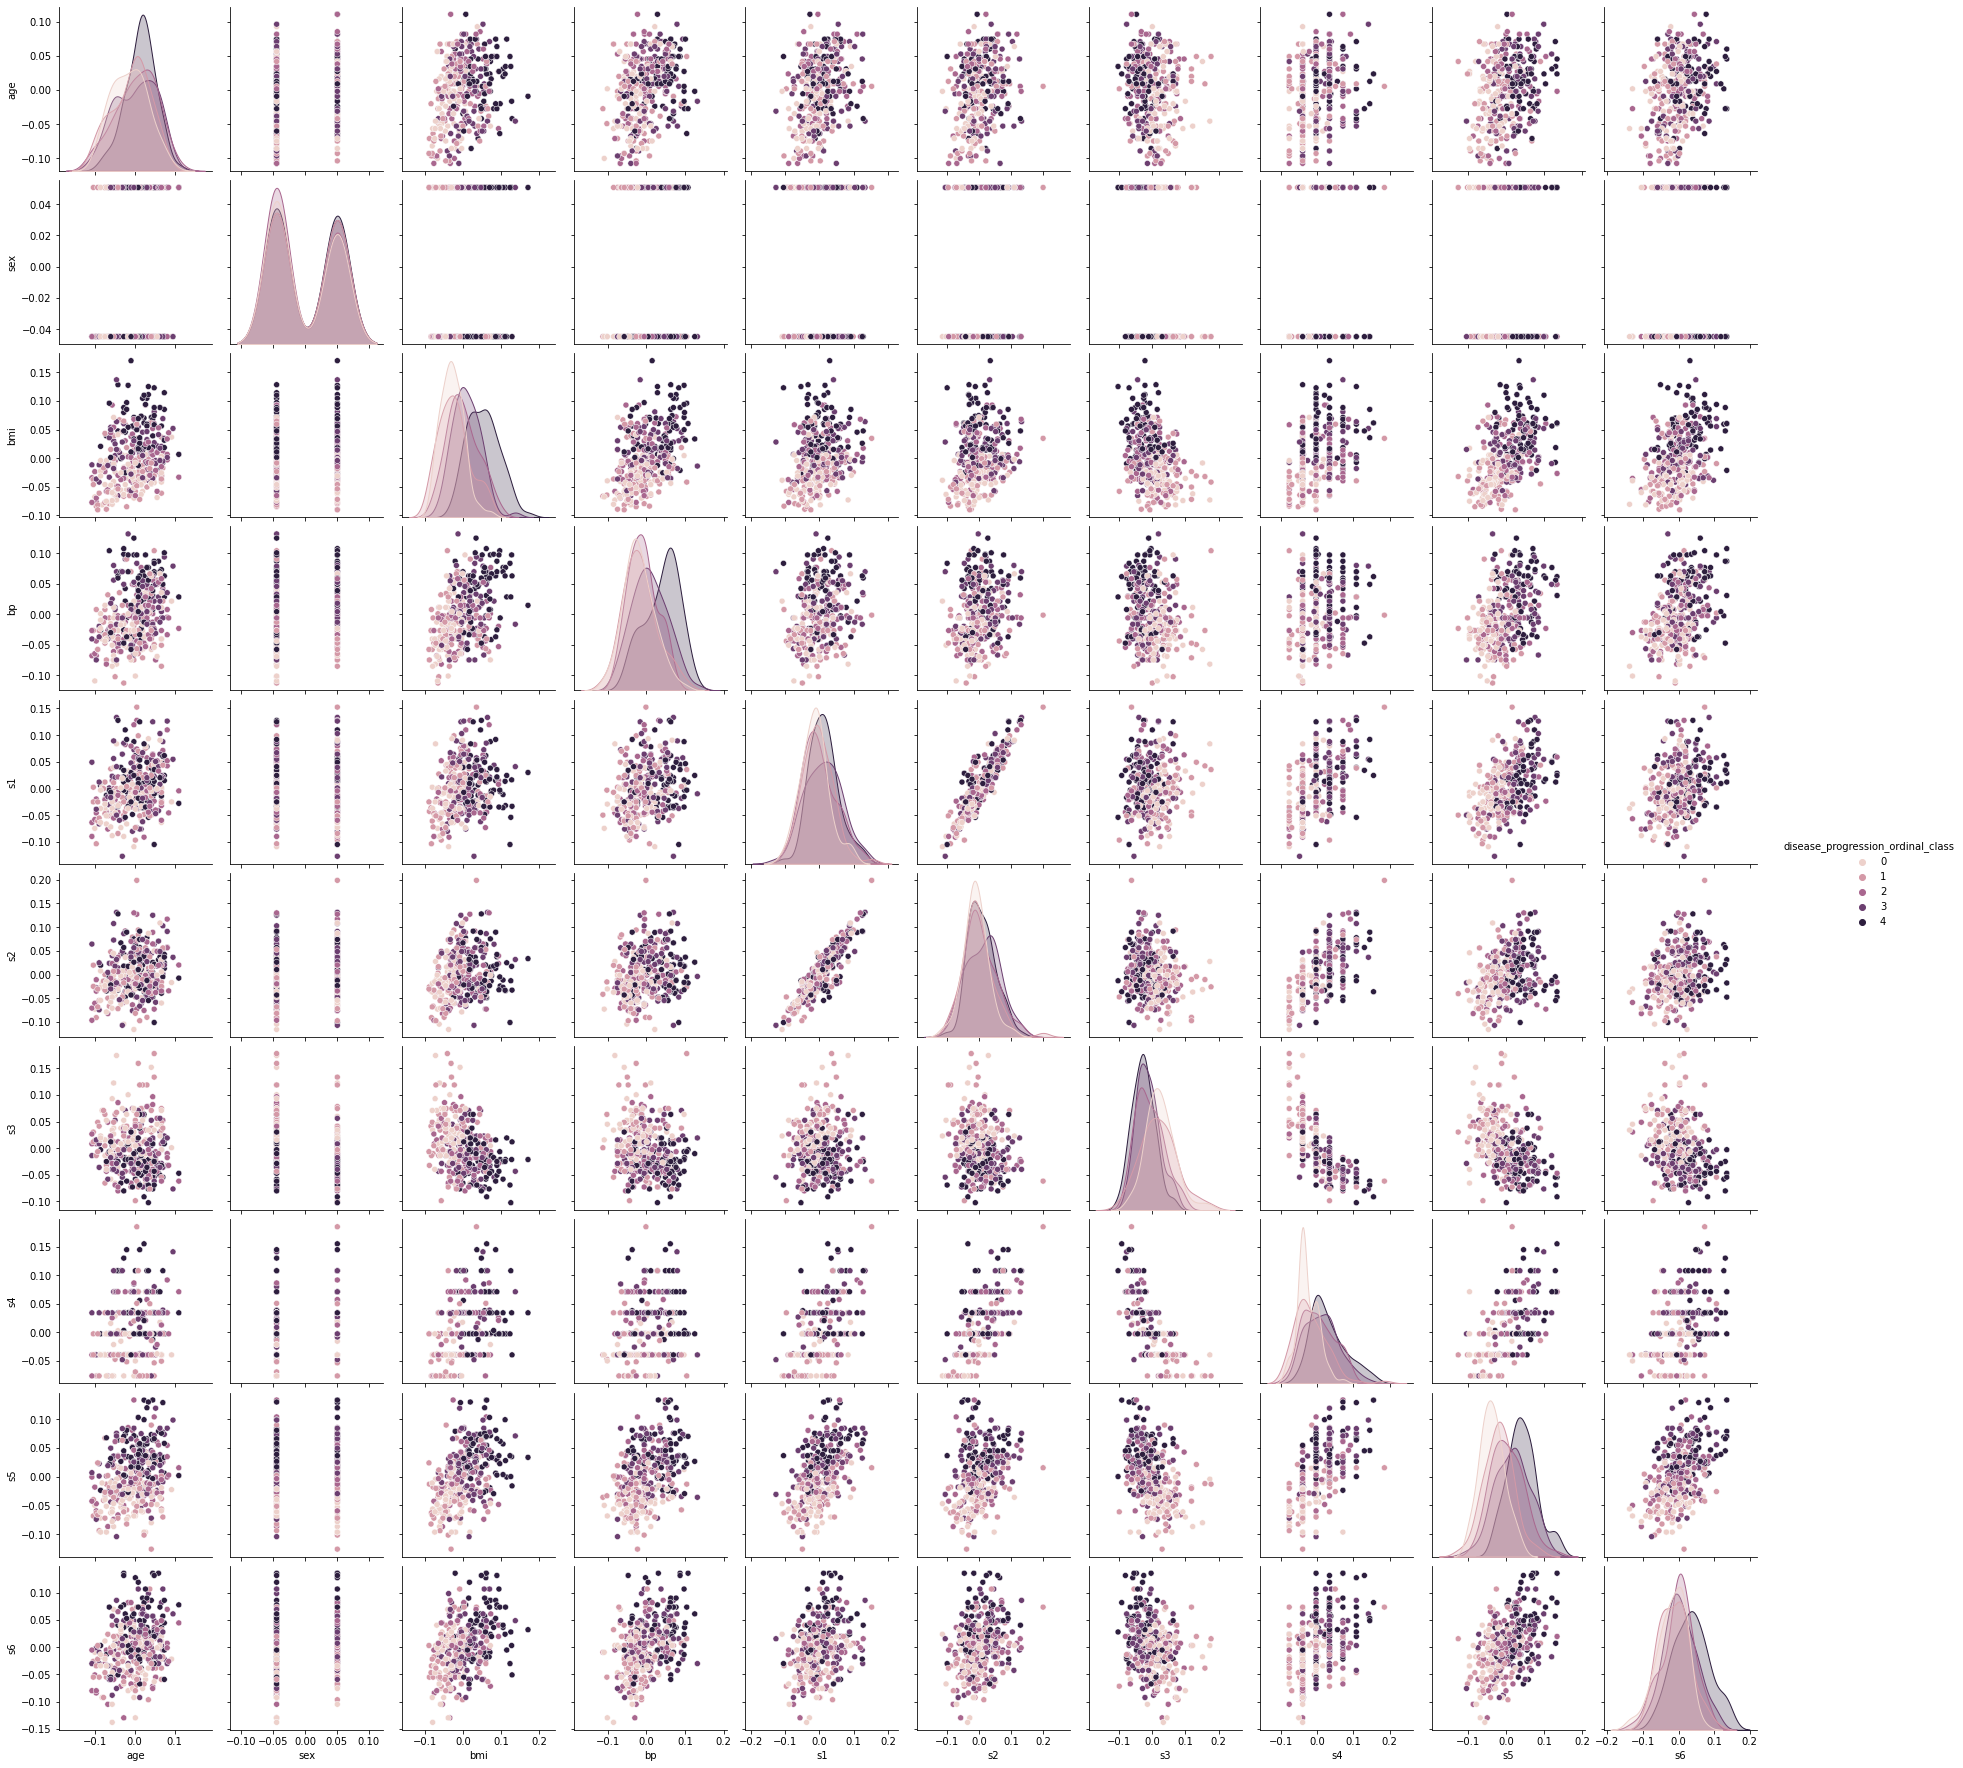

In [8]:
train_data = X_train.copy()
train_data['disease_progression_ordinal_class'] = y_train_ordinal
sns.pairplot(train_data, hue='disease_progression_ordinal_class')

# Ordinal Regression

We can view the structure of the model to be set up below:

<div>
<center>
<img src="../res/tensorflow_clm_model.png" width="500"/>
</center>
</div>

### TensorFlow Keras Model

TensorFlow is not the most intuitive deep learning architecture package to use, which is why we outline each layer creation here.

In [9]:
# Set up the input and dense layer
input = tf.keras.Input(shape=(X_train.shape[-1],), name='Diabetes_Features')
dense_layer = tf.keras.layers.Dense(1, name='Latent_Linear')(input)

# Set up cutpoints layer
# Initialize random values for cutpoint padding variables
random_values = tf.random.normal(shape=(n_classes - 2,))

# Set up layer to learn padding variables
# - Uses softplus activation function so that padding variables are unconstrained and always positive
padding_layer = tfp.layers.VariableLayer(shape=(n_classes - 2,),
                                        activation=tf.math.softplus,
                                        initializer=lambda shape, dtype: 
                                                tfp.util.TransformedVariable(
                                                    initial_value=random_values,
                                                    bijector=tfb.Scale(scale=1.),
                                                    dtype=dtype),
                                        # regularizer=tf.keras.regularizers.l2(),
                                        name='Padding_Variable'
                                        )(input)

# Set up CLM layer
ordinal_layer = tfp.layers.DistributionLambda(
    lambda t: CumulativeLink(
        loc=t[0], # Dense logits
        cutpoints=tf.cumsum(tf.concat([[0.], t[1]], axis=-1)) # Convert padding to cutpoints with first constrained at 0
    ), 
    name='CLM'
)([dense_layer, padding_layer])

# Set up and compile model
ordinal_model = tf.keras.Model(inputs=input, outputs=ordinal_layer, name='Simple-CLM')
ordinal_model.compile(optimizer=Adam(lr=0.05), loss=NegativeLogLikelihood())
history = ordinal_model.fit(X_train, y_train_ordinal, epochs=100)

Epoch 1/100


12/12 [==============================] - 0s 2ms/step - loss: 1.8210
Epoch 2/100
12/12 [==============================] - 0s 2ms/step - loss: 1.5921
Epoch 3/100
12/12 [==============================] - 0s 2ms/step - loss: 1.4982
Epoch 4/100
12/12 [==============================] - 0s 2ms/step - loss: 1.4474
Epoch 5/100
12/12 [==============================] - 0s 2ms/step - loss: 1.4185
Epoch 6/100
12/12 [==============================] - 0s 2ms/step - loss: 1.3974
Epoch 7/100
12/12 [==============================] - 0s 2ms/step - loss: 1.3826
Epoch 8/100
12/12 [==============================] - 0s 2ms/step - loss: 1.3727
Epoch 9/100
12/12 [==============================] - 0s 2ms/step - loss: 1.3651
Epoch 10/100
12/12 [==============================] - 0s 2ms/step - loss: 1.3538
Epoch 11/100
12/12 [==============================] - 0s 2ms/step - loss: 1.3381
Epoch 12/100
12/12 [==============================] - 0s 2ms/step - loss: 1.3298
Epoch 13/100
12/12 [=============================

<function matplotlib.pyplot.show(close=None, block=None)>

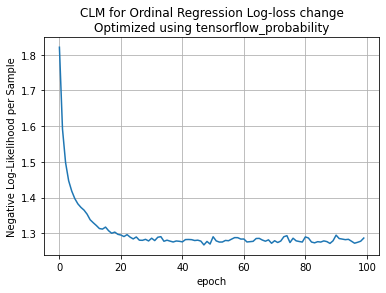

In [10]:
# Plot Training loss
plt.plot(history.history['loss'])
plt.xlabel('epoch')
plt.ylabel('Negative Log-Likelihood per Sample')
plt.title('CLM for Ordinal Regression Log-loss change\nOptimized using tensorflow_probability')
plt.grid()
plt.show

In [11]:
# Model Summary
tf.print(ordinal_model.summary())
print(ordinal_model.trainable_weights)

Model: "Simple-CLM"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Diabetes_Features (InputLayer)  [(None, 10)]         0                                            
__________________________________________________________________________________________________
Latent_Linear (Dense)           (None, 1)            11          Diabetes_Features[0][0]          
__________________________________________________________________________________________________
Padding_Variable (VariableLayer (3,)                 3           Diabetes_Features[0][0]          
__________________________________________________________________________________________________
CLM (DistributionLambda)        ((None, 1), (None, 1 0           Latent_Linear[0][0]              
                                                                 Padding_Variable[0][0]  

In [12]:
# Predictions and probability scores for each dataset
y_train_pred = ordinal_model.predict(X_train)
y_test_pred = ordinal_model.predict(X_test)

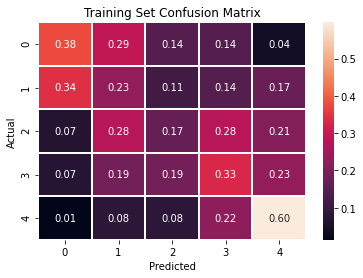

In [13]:
# Training Confusion Matrix
cf_matrix = confusion_matrix(y_train_ordinal, y_train_pred, normalize='true', labels=list(range(n_classes)))

ax = sns.heatmap(cf_matrix, linewidths=1, annot=True, fmt='.2f')
ax.set_ylabel(f'Actual')
ax.set_xlabel(f'Predicted')
ax.set_title(f'Training Set Confusion Matrix')
plt.show()

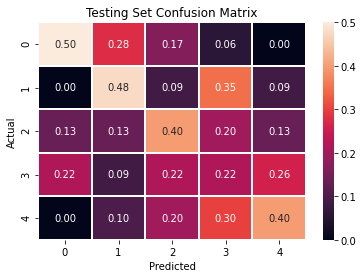

In [14]:
# Testing Confusion Matrix
cf_matrix = confusion_matrix(y_test_ordinal, y_test_pred, normalize='true',labels=list(range(n_classes)))

ax = sns.heatmap(cf_matrix, linewidths=1, annot=True, fmt='.2f')
ax.set_ylabel(f'Actual')
ax.set_xlabel(f'Predicted')
ax.set_title(f'Testing Set Confusion Matrix')
plt.show()

**Discussion:** 

Although the model clearly trains some latent weights and cutpoints, we notice fairly poor performance on the ordinal class prediction. In order to get a better sense of what is being learnt and whether it is sensible, we can utilize dimensionality reduction via PCA to project the data onto the dimensions of highest variance. This will allow us to train a new model with just two features to visualize the fit.

## Ordinal Regression with Dimensionality Reduction for Visualization

### Reduce the dimensions of the input data to 2 dimensions

In [15]:
pca = PCA(n_components=2, random_state=random_state).fit(X_train)
X_train_2d = pca.transform(X_train)
X_test_2d = pca.transform(X_test)

### Create and train new model

In [16]:
# Set up the input and dense layer
input = tf.keras.Input(shape=(X_train_2d.shape[-1],), name='PCA_2_Features')
dense_layer = tf.keras.layers.Dense(1, name='Latent_Linear')(input)

# Set up cutpoints layer
# Initialize random values for cutpoint padding variables
random_values = tf.random.normal(shape=(n_classes - 2,))

# Set up layer to learn padding variables
# - Uses softplus activation function so that padding variables are unconstrained and always positive
padding_layer = tfp.layers.VariableLayer(shape=(n_classes - 2,),
                                        activation=tf.math.softplus,
                                        initializer=lambda shape, dtype: 
                                                tfp.util.TransformedVariable(
                                                    initial_value=random_values,
                                                    bijector=tfb.Scale(scale=1.),
                                                    dtype=dtype),
                                        # regularizer=tf.keras.regularizers.l2(),
                                        name='Padding_Variable'
                                        )(input)

# Set up CLM layer
ordinal_layer = tfp.layers.DistributionLambda(
    lambda t: CumulativeLink(
        loc=t[0], # Dense logits
        cutpoints=tf.cumsum(tf.concat([[0.], t[1]], axis=-1)) # Convert padding to cutpoints with first constrained at 0
    ), 
    name='CLM'
)([dense_layer, padding_layer])

# Set up and compile model
ordinal_pca_model = tf.keras.Model(inputs=input, outputs=ordinal_layer, name='Simple-CLM-with-PCA')
ordinal_pca_model.compile(optimizer=Adam(lr=0.05), loss=NegativeLogLikelihood())
history = ordinal_pca_model.fit(X_train_2d, y_train_ordinal, epochs=100)

Epoch 1/100
12/12 [==============================] - 0s 2ms/step - loss: 1.8482
Epoch 2/100
12/12 [==============================] - 0s 2ms/step - loss: 1.6613
Epoch 3/100
12/12 [==============================] - 0s 2ms/step - loss: 1.5908
Epoch 4/100
12/12 [==============================] - 0s 2ms/step - loss: 1.5369
Epoch 5/100
12/12 [==============================] - 0s 2ms/step - loss: 1.5082
Epoch 6/100
12/12 [==============================] - 0s 2ms/step - loss: 1.4920
Epoch 7/100
12/12 [==============================] - 0s 2ms/step - loss: 1.4687
Epoch 8/100
12/12 [==============================] - 0s 2ms/step - loss: 1.4640
Epoch 9/100
12/12 [==============================] - 0s 2ms/step - loss: 1.4428
Epoch 10/100
12/12 [==============================] - 0s 2ms/step - loss: 1.4347
Epoch 11/100
12/12 [==============================] - 0s 2ms/step - loss: 1.4330
Epoch 12/100
12/12 [==============================] - 0s 2ms/step - loss: 1.4218
Epoch 13/100
12/12 [=================

<function matplotlib.pyplot.show(close=None, block=None)>

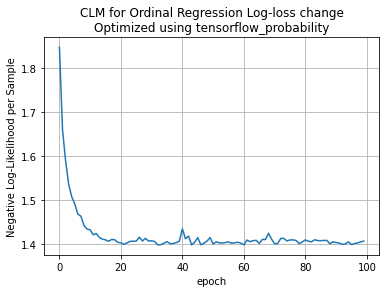

In [17]:
# Plot Training loss
plt.plot(history.history['loss'])
plt.xlabel('epoch')
plt.ylabel('Negative Log-Likelihood per Sample')
plt.title('CLM for Ordinal Regression Log-loss change\nOptimized using tensorflow_probability')
plt.grid()
plt.show

In [18]:
# Model Summary
tf.print(ordinal_pca_model.summary())
print(ordinal_pca_model.trainable_weights)

Model: "Simple-CLM-with-PCA"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
PCA_2_Features (InputLayer)     [(None, 2)]          0                                            
__________________________________________________________________________________________________
Latent_Linear (Dense)           (None, 1)            3           PCA_2_Features[0][0]             
__________________________________________________________________________________________________
Padding_Variable (VariableLayer (3,)                 3           PCA_2_Features[0][0]             
__________________________________________________________________________________________________
CLM (DistributionLambda)        ((None, 1), (None, 1 0           Latent_Linear[0][0]              
                                                                 Padding_Variabl

In [19]:
# Predictions and probability scores for each dataset
y_train_pred = ordinal_pca_model.predict(X_train_2d)
y_test_pred = ordinal_pca_model.predict(X_test_2d)

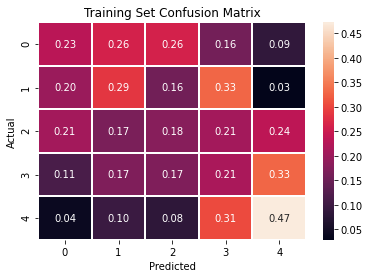

In [20]:
# Training Confusion Matrix
cf_matrix = confusion_matrix(y_train_ordinal, y_train_pred, normalize='true', labels=list(range(n_classes)))

ax = sns.heatmap(cf_matrix, linewidths=1, annot=True, fmt='.2f')
ax.set_ylabel(f'Actual')
ax.set_xlabel(f'Predicted')
ax.set_title(f'Training Set Confusion Matrix')
plt.show()

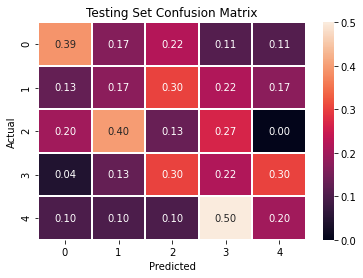

In [21]:
# Testing Confusion Matrix
cf_matrix = confusion_matrix(y_test_ordinal, y_test_pred, normalize='true',labels=list(range(n_classes)))

ax = sns.heatmap(cf_matrix, linewidths=1, annot=True, fmt='.2f')
ax.set_ylabel(f'Actual')
ax.set_xlabel(f'Predicted')
ax.set_title(f'Testing Set Confusion Matrix')
plt.show()

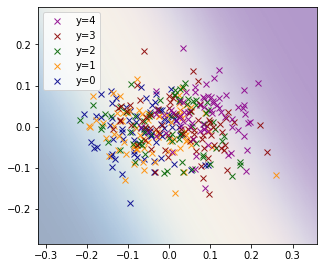

In [22]:
plot_model(ordinal_pca_model, X_train_2d, y_train_ordinal.squeeze(), pad=0.1)

**Discussion**:

We observe that although there is reasonable separation of the data between the first and last ordinal class, there is considerable overlap in the data for all classes. This explains why utilizing the raw (and normalized) data at input features `phi(x)` is not able to achieve high prediction performance. A more sophisticated method, such as deep learning or kernel transformations, should be utilized to learn the non-linear separations of the data.